In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import PIL
from os import listdir
from PIL import Image
import random

import tensorflow as tf
from tensorflow import data
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.keras.constraints import Constraint
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd drive/MyDrive/WGAIN

[Errno 2] No such file or directory: 'drive/MyDrive/WGAIN'
/content/drive/MyDrive/WGAIN


In [ ]:
%ls

datasets/  saved_models/  WGAIN.ipynb


In [ ]:
## Model builds
## Generator
def build_generator(side):
    # inputs
    data = keras.Input(shape=(side,side,3), name="data")
    mask = keras.Input(shape=(side,side,1), name="mask")
    random = keras.Input(shape=(side,side,3), name="random")
    # main part
    x0 = layers.Concatenate()([data, mask, random])
    # the real functional layers
    x11 = layers.Conv2D(32, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(x0)
    x12 = layers.Conv2D(32, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(x0)
    x13 = layers.Conv2D(64, 5, activation=ELU(), padding = 'same')(x0)
    x1o = layers.Concatenate()([x11, x12, x13])
    x1 = layers.MaxPool2D(2)(x1o)
    x21 = layers.Conv2D(32, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(x1)
    x22 = layers.Conv2D(32, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(x1)
    x23 = layers.Conv2D(64, 5, activation=ELU(), padding = 'same')(x1)
    x2o = layers.Concatenate()([x21, x22, x23])
    x2 = layers.MaxPool2D(2)(x2o)
    x31 = layers.Conv2D(64, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(x2)
    x32 = layers.Conv2D(64, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(x2)
    x33 = layers.Conv2D(128, 5, activation=ELU(), padding = 'same')(x2)
    x3o = layers.Concatenate()([x31, x32, x33])
    x3 = layers.MaxPool2D(2)(x3o)
    y11 = layers.Conv2D(128, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(x3)
    y12 = layers.Conv2D(128, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(x3)
    y13 = layers.Conv2D(256, 5, activation=ELU(), padding = 'same')(x3)
    y1o = layers.Concatenate()([y11, y12, y13])
    y1 = layers.UpSampling2D(2)(y1o)
    y1 = layers.Concatenate()([y1, x3o])
    y21 = layers.Conv2DTranspose(64, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(y1)
    y22 = layers.Conv2DTranspose(64, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(y1)
    y23 = layers.Conv2DTranspose(128, 5, activation=ELU(), padding = 'same')(y1)
    y2o = layers.Concatenate()([y21, y22, y23])
    y2 = layers.UpSampling2D(2)(y2o)
    y2 = layers.Concatenate()([y2, x2o])
    y31 = layers.Conv2DTranspose(32, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(y2)
    y32 = layers.Conv2DTranspose(32, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(y2)
    y33 = layers.Conv2DTranspose(64, 5, activation=ELU(), padding = 'same')(y2)
    y3o = layers.Concatenate()([y31, y32, y33])
    y3 = layers.UpSampling2D(2)(y3o)
    y3 = layers.Concatenate()([y3, x1o])
    y41 = layers.Conv2DTranspose(32, 5, dilation_rate = 2, activation=ELU(), padding = 'same')(y3)
    y42 = layers.Conv2DTranspose(32, 5, dilation_rate = 5, activation=ELU(), padding = 'same')(y3)
    y43 = layers.Conv2DTranspose(64, 5, activation=ELU(), padding = 'same')(y3)
    y4o = layers.Concatenate()([y41, y42, y43, x0])
    y5 = layers.Conv2DTranspose(8, 3, padding="same", activation=ELU())(y4o)
    y = layers.Conv2DTranspose(3, 3, padding="same", activation='hard_sigmoid')(y5)
    generator = keras.Model([data, mask, random], y, name='generator')
    return generator

## Discriminator
def norm_clip(weights):
    return tf.clip_by_norm(weights, 1.0)
def build_critic(side):
    imputed = keras.Input(shape=(side,side,3), name="imputed")
    mask = keras.Input(shape=(side,side,1), name="mask")
    x = layers.Concatenate()([imputed, mask])
    x = layers.Conv2D(64, 5, strides=2, kernel_constraint = norm_clip)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 5, strides=2, kernel_constraint = norm_clip)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 5, strides=2, kernel_constraint = norm_clip)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 5, strides=2, kernel_constraint = norm_clip)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, 5, strides=2, kernel_constraint = norm_clip)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, "linear", kernel_constraint = norm_clip)(x)
    critic = keras.Model([imputed,mask], x, name='critic')
    return critic

In [ ]:
## Loss functions
@tf.function
def g_loss(original, imputed):
    return keras.losses.MAE(original, imputed)

@tf.function
def wass_c_loss(opinion_generated, opinion_real):
    return (tf.reduce_mean(tf.multiply(-1 * tf.ones_like(opinion_generated), opinion_generated)) + tf.reduce_mean(tf.multiply(tf.ones_like(opinion_real), opinion_real)))

@tf.function
def wass_g_loss(opinion):
    return tf.reduce_mean(tf.multiply(tf.ones_like(opinion), opinion))

In [ ]:
## Dataset
def prepare_training_dataset(ds, batch_size, side):
    def decode_img(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    def introduce_missingness(X):
        # noise mask
        # per row ratios how much should be thrown (each row a different number, max is max_ratio_to_throw)
        ratio_to_throw = tf.random.uniform((X.shape[0],), minval = 0.50, maxval = 0.95)
        ratio_to_throw = tf.reshape(ratio_to_throw, ratio_to_throw.shape + [1, 1])
        ratio_to_throw = tf.repeat(ratio_to_throw, [side], axis = 1)
        ratio_to_throw = tf.repeat(ratio_to_throw, [side], axis = 2)
        ratio_to_throw = tf.reshape(ratio_to_throw, [X.shape[0], side, side, 1])
        # binary mask of which features are left (0 - missing, 1 - OK)
        mask_noise = tf.dtypes.cast(tf.math.greater(tf.random.uniform([X.shape[0], side, side, 1]), ratio_to_throw), tf.float32)
        # centered square
        sides = np.random.randint(low = side//2.5, high = side//1.6, size=batch_size)
        corner_l = int(side / 2.0) -  (sides/2.0).astype(int)
        corner_u = int(side / 2.0) +  (sides/2.0).astype(int)
        center_mask = np.ones((batch_size, side, side, 1)).astype('float32')
        for i in range(batch_size):
            center_mask[i,corner_l[i]:corner_u[i],corner_l[i]:corner_u[i],:] = 0
        center_mask = tf.constant(center_mask, dtype=tf.float32)
        # several squares
        N = 30
        ll_x = np.random.randint(low = -side*2, high = side*3, size=(X.shape[0], N))
        ll_y = np.random.randint(low = -side*2, high = side*3, size=(X.shape[0], N))
        sizes = np.random.randint(low = side//5, high = side//3, size=(X.shape[0], N))
        ur_x = ll_x + sizes
        ur_y = ll_y + sizes
        mask_squares = np.ones((X.shape[0], side, side, 1)).astype('float32')
        for j in range(X.shape[0]):
            for i in range(N):
                mask_squares[j,ll_x[j,i]:ur_x[j,i],ll_y[j,i]:ur_y[j,i],:] = 0
        mask_squares = tf.constant(mask_squares, dtype=tf.float32)
        # agregate mask randomly for each image
        ratio_to_agg = tf.random.uniform((X.shape[0],), minval = 0, maxval = 0.9)
        ratio_to_agg = tf.reshape(ratio_to_agg, ratio_to_agg.shape + [1, 1])
        ratio_to_agg = tf.repeat(ratio_to_agg, [side], axis = 1)
        ratio_to_agg = tf.repeat(ratio_to_agg, [side], axis = 2)
        ratio_to_agg = tf.reshape(ratio_to_agg, [X.shape[0], side, side, 1])
        choice_1 = tf.dtypes.cast(tf.math.less(ratio_to_agg, 0.3), tf.float32)
        choice_2 = tf.dtypes.cast(tf.math.greater(ratio_to_agg, 0.6), tf.float32)
        choice_3 = 1 - choice_1 - choice_2
        mask = tf.math.multiply(choice_1, mask_noise) + tf.math.multiply(choice_2, mask_squares) + tf.math.multiply(choice_3, center_mask)
        # Do the mask to have 3 channels
        mask3 = tf.repeat(mask, [3], axis = 3)
        # prepare randomness
        randZ = tf.random.normal([X.shape[0], side, side, 3], mean = 0.0, stddev = 0.1)
        randZ = tf.math.multiply(1 - mask3, randZ)
        # apply the mask - leave original and substitute randoms for missings
        newX = tf.math.multiply(mask3, X)
        # return a training pair
        return (X, newX, mask, randZ)
    # do the preparation
    ds = ds.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 1024)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.map(introduce_missingness, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
batch_size = 32
side = 128
nb_epochs=200
path = "./datasets/celeba/%s128"
celeba_train = data.Dataset.list_files(path%'train' + str('/*.jpg'))
celeba_train_d = prepare_training_dataset(celeba_train, batch_size, side)
# create the model
generator = build_generator(side)
critic = build_critic(side)
# print summaries
generator.summary()
critic.summary()
# prepare optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.00005)
critic_optimizer = tf.keras.optimizers.Adam(0.00005)


@tf.function
def train_step(origX, newX, mask, randZ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as critic_tape:
        g_out = generator([newX, mask, randZ])
        opinion_generated = critic([g_out, mask])
        opinion_real = critic([origX, mask])
        critic_w_l = wass_c_loss(opinion_generated, opinion_real)
        gen_w_l = 0.005*wass_g_loss(opinion_generated)
        gen_mse_l = g_loss(g_out, origX)
        gen_loss = gen_mse_l + gen_w_l

    g_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    c_gradients = critic_tape.gradient(critic_w_l, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(c_gradients,critic.trainable_variables))
    generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    return gen_mse_l, gen_w_l, critic_w_l

##### Main training
g_history = []
m_history = []
d_history = []

# Path to save
model_path = "saved_models_celeba/"

# main loop
for epoch in range(1,nb_epochs+1):
    print("Epoch: %d" % epoch)
    # Store selected losses
    losses_g = []
    losses_m = []
    losses_d = []
    for i, (origX, newX, mask, randZ) in enumerate(celeba_train_d):
        print(".", end='', flush=True)
        mse_l, genw_l, critic_l = train_step(origX, newX, mask, randZ)
        losses_m.append(mse_l)
        losses_g.append(genw_l)
        losses_d.append(critic_l)
    print()
    g_history.append(np.mean(losses_g))
    m_history.append(np.mean(losses_m))
    d_history.append(np.mean(losses_d))
    print("gen W loss:", np.mean(losses_g))
    print("gen mae loss:", np.mean(losses_m))
    print("critic loss:", np.mean(losses_d))
    generator.save_weights("saved_models_celeba/generator_latest")
    critic.save_weights("saved_models_celeba/discriminator_latest")
    if epoch%1==0:
        generator.save_weights("saved_models_celeba/generator_ckpt%d" % epoch)
        critic.save_weights("saved_models_celeba/discriminator_ckpt%d" % epoch)


# Final save of weights
generator.save_weights("saved_models_celeba/generator_final")
critic.save_weights("saved_models_celeba/discriminator_final")

In [ ]:
batch_size = 10
side = 128

path = "datasets/celeba/%s128"
celeba_test = data.Dataset.list_files(path%'test' + str('/*.jpg'))
celeba_test_d = prepare_training_dataset(celeba_test, batch_size, side)

# create the model
generator = build_generator(side)
# generator.summary()
critic = build_critic(side)
# critic.summary()

# Load weights
model_path = "saved_models/"

generator.load_weights(model_path + "generator_final")
critic.load_weights(model_path + "discriminator_final")

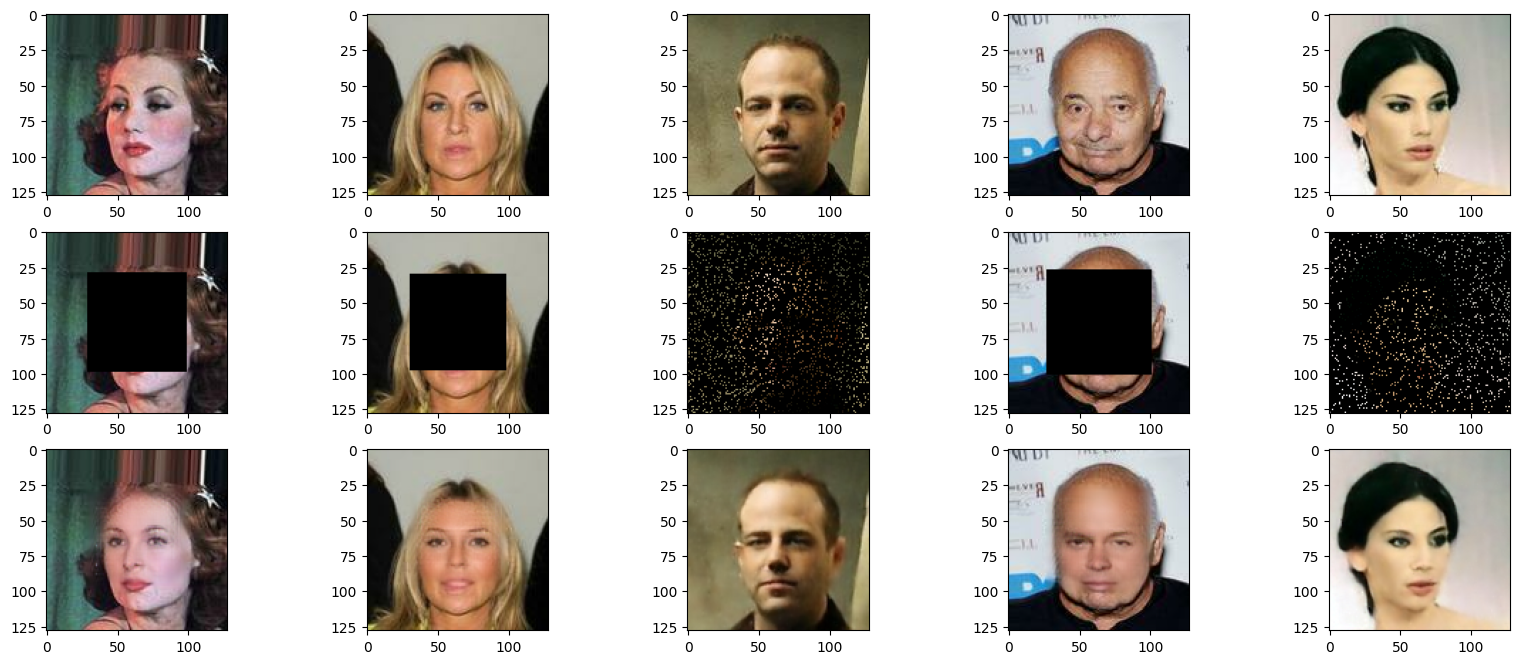

In [ ]:
it = iter(celeba_test_d)
origX, newX, mask, randZ = next(it)
g_out = generator([newX, mask, randZ])
plt.figure(figsize=(20,8))
for i in range(min(5, batch_size)):
    plt.subplot(3,5,i+1)
    plt.imshow(origX[i,:,:,:])
    plt.subplot(3,5,i+6)
    plt.imshow(newX[i,:,:,:])
    plt.subplot(3,5,i+11)
    plt.imshow(g_out[i,:,:,:])
plt.show()